Script to treat MF data for SECOS project

In [1]:
import sys
import os
import dill
import pickle
import numpy as np
import pandas as pd
import rpy2.robjects as ro
import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter  # ConciseDateFormatter

from config import *

In [2]:
### CST ###

datafile = DATADIR + '/SECOS/precip.Rdata'
ymin = 1950
ymax = 2022
dates = pd.date_range('{0}-01-01'.format(ymin), '{0}-03-26'.format(2023), freq='D')  # MF data -> march 2023
years = np.arange(1950, 2022+1, 1)  # study period with full years
th_dd = 1.   # Dry day threshold
months = [6, 7, 8]
p_cum = 0.1  # seasonal culumative rainfall "extreme" percentile
p_dry = 0.9  # dry spell length "extreme" percentile

r = ro.r
r['source']('kde1d.R')
make_kde1d = ro.globalenv['make_kde1d']    # Load R function for KDE fit
make_pkde1d = ro.globalenv['make_pkde1d']  # Load R function for KDE CDF

R[write to console]: Le chargement a nécessité le package : kde1d



In [3]:
# Load stations precipitation data
r['load'](datafile)
df_r = r['df']
arr = np.array(df_r)

In [4]:
df = pd.DataFrame(columns=df_r.colnames, index=dates)
for ista, sta in enumerate(df_r.colnames):
    df[sta] = arr[ista,]
df = df.loc[df[df.index.year == 1950].index[0]:df[df.index.year == 2022].index[-1]]  # remove 2023

In [5]:
df

,LG,LM
1950-01-01,NaN,0.0
1950-01-02,NaN,12.3
1950-01-03,NaN,0.0
1950-01-04,NaN,0.0
1950-01-05,NaN,0.0
...,...,...
2022-12-27,0.0,0.0
2022-12-28,0.0,0.0
2022-12-29,0.3,0.9
2022-12-30,15.0,8.3


In [6]:
# Get 1950-2022 mean seasonal cycle
df_monthly = df.groupby(df.index.month).mean()

0 0 : 0 1 : 0 2 : 0 3 : 0 4 : 1 0 : 1 1 : 1 2 : 1 3 : 1 4 : 

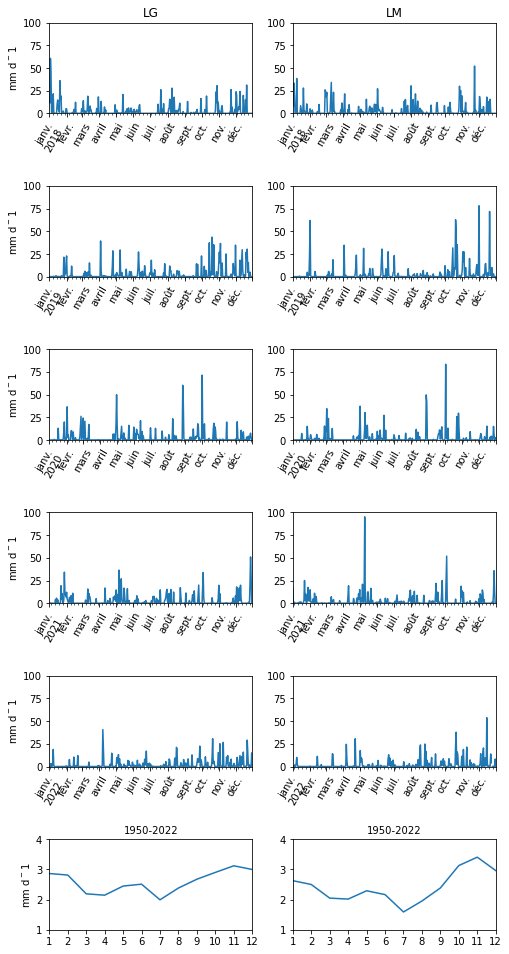

In [7]:
#~ Plot

years_laut = [2018, 2019, 2020, 2021, 2022]

fig1, ax1 = plt.subplots(nrows=6, ncols=2, figsize=(8., 14.))

plt.subplots_adjust(bottom=0.05, top=0.95, hspace=0.8)

for ista, sta in enumerate(df.columns):
    for iy, y in enumerate(years_laut):
        print(ista, iy, end=' : ', flush=True)
        ax_ = ax1[iy][ista]
        df[sta][df.index.year == y].plot(ax=ax_)
        
        if iy == 0:
            ax_.set_title(sta)
        if ista == 0:
            ax_.set_ylabel('mm d$^-1$')
        ax_.set_ylim(0., 100.)
            
        ax_.tick_params(axis='x', labelrotation=60)

        if iy == 4:
            ax1[5][ista].plot(df_monthly[sta].index, df_monthly[sta].values)
            ax1[5][ista].set_xticks(df_monthly.index)
            ax1[5][ista].set_xticklabels(df_monthly.index)
            ax1[5][ista].set_xlim(1, 12)
            ax1[5][ista].set_ylim(1., 4.)
            ax1[5][ista].set_title('{0}-{1}'.format(ymin, ymax), fontsize=10)
            if ista == 0:
                ax1[5][ista].set_ylabel('mm d$^-1$')


#~ Save

figdir = FIGDIR + '/secos_precip_validation.pdf'
fig1.savefig(figdir)

In [8]:
# Get dry spell length
dsl_years_stas = {}
dsl_years_max_stas = {}

for sta in df.columns:
    print('\n{0}'.format(sta))
    dsl_years = []
    dsl_years_max = pd.Series(index=years)

    for y in years:
        print(y, end=' : ', flush=True)
        df_y = df[df.index.year == y]
        df_y_sea = df_y.loc[df_y[df_y.index.month == months[0]].index[0]:df_y[df_y.index.month == months[-1]].index[-1]]

        df_y_sea_ = pd.DataFrame({'date': df_y_sea[sta].index, 'dr': df_y_sea[sta].values}, index=range(len(df_y_sea.index)))
        df_y_sea_['nonnull'] = (df_y_sea_['dr'] > th_dd)
    
        idxs_nn = df_y_sea_[df_y_sea_['nonnull']==True].index  # Get index of rainy days (> threshold)
    
        dsl = []  # Get dry spells length of year (over june-july-august)
        for i, idx_nn in enumerate(idxs_nn):
            if i == 0:
                dsl.append(idx_nn)
            elif (i != 0) and (i != len(idxs_nn)-1):
                dsl.append(idx_nn-idxs_nn[i-1]-1)
            elif (i == len(idxs_nn)-1) and (idx_nn != len(df_y_sea_)-1): # dernier jour pluvieux != dernier jour du mois
                dsl.append(len(df_y_sea_)-idx_nn-2)
            elif (i == len(idxs_nn)-1) and (idx_nn == len(df_y_sea_)-1): # dernier jour pluvieux = dernier jour du mois
                dsl.append(idx_nn - idxs_nn[i-1]-1)
        dsl = np.asarray(dsl)
        dsl_years.append(dsl[dsl != 0])
        dsl_years_max.loc[y] = dsl.max()

    #dsl_years = np.concatenate(dsl_years)
    dsl_years_stas[sta] = dsl_years
    dsl_years_max_stas[sta] = dsl_years_max


LG
1950 : 1951 : 1952 : 1953 : 1954 : 1955 : 1956 : 1957 : 1958 : 1959 : 1960 : 1961 : 1962 : 1963 : 1964 : 

<ipython-input-8-41c61fa979ad>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dsl_years_max = pd.Series(index=years)


1965 : 1966 : 1967 : 1968 : 1969 : 1970 : 1971 : 1972 : 1973 : 1974 : 1975 : 1976 : 1977 : 1978 : 1979 : 1980 : 1981 : 1982 : 1983 : 1984 : 1985 : 1986 : 1987 : 1988 : 1989 : 1990 : 1991 : 1992 : 1993 : 1994 : 1995 : 1996 : 1997 : 1998 : 1999 : 2000 : 2001 : 2002 : 2003 : 2004 : 2005 : 2006 : 2007 : 2008 : 2009 : 2010 : 2011 : 2012 : 2013 : 2014 : 2015 : 2016 : 2017 : 2018 : 2019 : 2020 : 2021 : 2022 : 
LM
1950 : 1951 : 1952 : 1953 : 1954 : 1955 : 1956 : 1957 : 1958 : 1959 : 1960 : 1961 : 1962 : 1963 : 1964 : 1965 : 1966 : 1967 : 1968 : 

<ipython-input-8-41c61fa979ad>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dsl_years_max = pd.Series(index=years)


1969 : 1970 : 1971 : 1972 : 1973 : 1974 : 1975 : 1976 : 1977 : 1978 : 1979 : 1980 : 1981 : 1982 : 1983 : 1984 : 1985 : 1986 : 1987 : 1988 : 1989 : 1990 : 1991 : 1992 : 1993 : 1994 : 1995 : 1996 : 1997 : 1998 : 1999 : 2000 : 2001 : 2002 : 2003 : 2004 : 2005 : 2006 : 2007 : 2008 : 2009 : 2010 : 2011 : 2012 : 2013 : 2014 : 2015 : 2016 : 2017 : 2018 : 2019 : 2020 : 2021 : 2022 : 

In [10]:
# Get CDF of dry spell length from gaussian KDE
dsl_cdf_stas = {}

for sta, dsl in dsl_years_stas.items():
    vals = np.concatenate(dsl)
    values = ro.FloatVector(vals.astype(float))
    tmp = make_kde1d(values)
    cdf = make_pkde1d(values, tmp)
    df_cdf = pd.DataFrame({'z': np.concatenate([vals, [np.nan]]), 'CDF': np.concatenate([cdf, [p_dry]])})
    df_cdf_sorted = df_cdf.sort_values(by='CDF').interpolate()  # -> get z90
    
    dsl_cdf_stas[sta] = df_cdf_sorted

In [12]:
# Get "extreme" dry spell length
z_dry_stas = {}
for sta in df.columns:
    idx_p = (np.abs(dsl_cdf_stas[sta]['CDF'] - p_dry)).argmin()
    z_dry = dsl_cdf_stas[sta]['z'].iloc[idx_p]
    z_dry_stas[sta] = z_dry

In [9]:
# Get indices of years with dry spell length > z90
idx_z_dry_stas = {}
for sta in df.columns:
    idx_z_dry = [i for i in range(len(dsl_years_stas[sta])) if True in (dsl_years_stas[sta][i] > z_dry_stas[sta])]
    idx_z_dry_stas[sta] = idx_z_dry

In [10]:
# Get seasonal cumulative rainfall
dfs = [df[df.index.month == m] for m in months]
df_ = pd.concat(dfs, axis=0).sort_index()
df_cum = df_.groupby(df_.index.year).sum()

In [12]:
# Get CDF of seasonal cumulative rainfall from years with dry spell lengths > z90
cum_cdf_stas = {}

for sta in df_cum.columns:
    df_cum_dry = df_cum[sta].iloc[idx_z_dry_stas[sta]]
    values = ro.FloatVector(df_cum_dry.values.astype(float))
    tmp = make_kde1d(values)
    cdf = make_pkde1d(values, tmp)
    cdf_cum = pd.DataFrame({'z': np.concatenate([df_cum_dry.values, [np.nan]]), 'CDF': np.concatenate([cdf, [p_cum]])})
    cdf_cum_sorted = cdf_cum.sort_values(by='CDF').interpolate()  # -> get z10
    
    cum_cdf_stas[sta] = cdf_cum_sorted

In [13]:
# Get "extreme" seasonal cumulative rainfall
z_cum_stas = {}
for sta in df.columns:
    idx_p = (np.abs(cum_cdf_stas[sta]['CDF'] - p_cum)).argmin()  # locate the nearest observed values to model z10
    z_cum = cum_cdf_stas[sta]['z'].iloc[idx_p]
    z_cum_stas[sta] = z_cum
z_cum_stas

{'LG': 131.35, 'LM': 100.5}

In [30]:
# Get seasonal max daily rainfall of all years
amax_stas = df_.groupby(df_.index.year).max()

# Get seasonal max daily rainfall of 'dry' years
amax_stas_dry = {}

for sta, idxs in idx_z_dry_stas.items():
    amax_sta_dry = amax_stas[sta].iloc[idxs]
    amax_stas_dry[sta] = amax_sta_dry

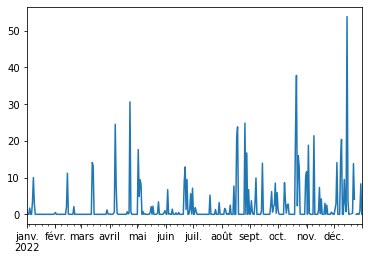

In [14]:
df[sta][df.index.year == y].plot()

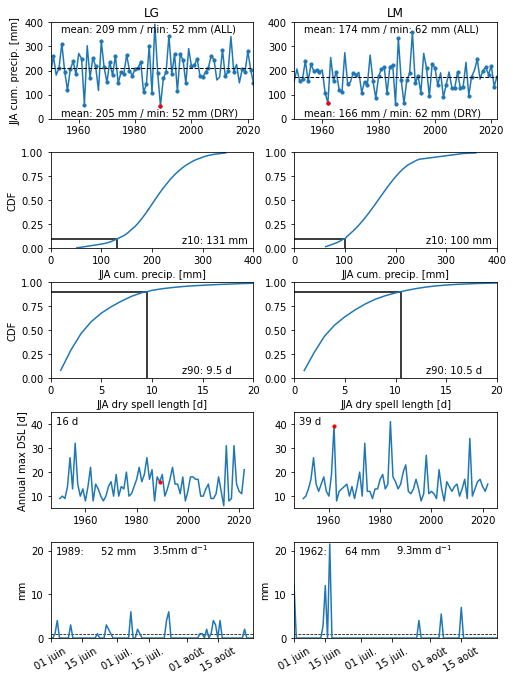

In [14]:
fig2, ax2 = plt.subplots(nrows=5, ncols=2, figsize=(8., 9.5))

plt.subplots_adjust(bottom=0.05, top=0.95, hspace=0.35)

ymax_sta = {'LG': 1989, 'LM': 1962}

for ista, sta in enumerate(df.columns):
    df_cum[sta].plot(ax=ax2[0][ista])
    ax2[0][ista].scatter(df_cum[sta].iloc[idx_z_dry_stas[sta]].index, df_cum[sta].iloc[idx_z_dry_stas[sta]], s=10)
    ax2[0][ista].scatter(ymax_sta[sta], df_cum[sta].loc[ymax_sta[sta]], s=10, color='r', zorder=100)  # years[idx_max]
    ax2[0][ista].hlines(df_cum[sta].mean(), ymin, ymax, ls='--', lw=1., zorder=100)
    ax2[0][ista].text(0.05, 0.9, 'mean: {0} mm / min: {1} mm (ALL)'.format(int(df_cum[sta].mean()), int(df_cum[sta].min())), transform=ax2[0][ista].transAxes)
    ax2[0][ista].text(0.05, 0.025, 'mean: {0} mm / min: {1} mm (DRY)'.format(int(df_cum[sta].iloc[idx_z_dry_stas[sta]].mean()), int(df_cum[sta].iloc[idx_z_dry_stas[sta]].min())), transform=ax2[0][ista].transAxes)
    ax2[0][ista].set_xlim(1950, 2022)
    ax2[0][ista].set_ylim(0., 400.)
    ax2[0][ista].set_title(sta)
    if ista == 0:
        ax2[0][ista].set_ylabel('JJA cum. precip. [mm]') #.format("-".join([str(m) for m in months])))
    
    cum_cdf_sta = cum_cdf_stas[sta]
    ax2[1][ista].plot(cum_cdf_sta['z'], cum_cdf_sta['CDF'])
    idx_p = (np.abs(cum_cdf_sta['CDF'] - p_cum)).argmin()
    z_dry = cum_cdf_sta['z'].iloc[idx_p]
    ax2[1][ista].set_xlim(0., 400.)
    ax2[1][ista].set_ylim(0., 1.)
    ax2[1][ista].set_xlabel('JJA cum. precip. [mm]') #.format("-".join([str(m) for m in months])))
    ax2[1][ista].vlines(z_dry, 0, p_cum)
    ax2[1][ista].hlines(p_cum, 0, z_dry)
    ax2[1][ista].text(0.65, 0.05, 'z{0}: {1} mm'.format(int(p_cum*100), int(z_dry)), transform=ax2[1][ista].transAxes)
    if ista == 0:
        ax2[1][ista].set_ylabel('CDF')

    dsl_cdf_sta = dsl_cdf_stas[sta]
    ax2[2][ista].plot(dsl_cdf_sta['z'], dsl_cdf_sta['CDF'])
    ax2[2][ista].set_xlim(0., 20.)
    ax2[2][ista].set_ylim(0., 1.)
    ax2[2][ista].set_xlabel('JJA dry spell length [d]')
    ax2[2][ista].vlines(z_dry_stas[sta], 0, p_dry)
    ax2[2][ista].hlines(p_dry, 0, z_dry_stas[sta])
    ax2[2][ista].text(0.65, 0.05, 'z{0}: {1} d'.format(int(p_dry*100), z_dry_stas[sta]), transform=ax2[2][ista].transAxes)
    if ista == 0:
        ax2[2][ista].set_ylabel('CDF')
    
    dsl_max_sta = dsl_years_max_stas[sta]
    #ymax = dsl_max_sta.idxmax()  # np.where(dsl_max_sta == dsl_max_sta.max())[0][0]
    ax2[3][ista].plot(years, dsl_max_sta)
    ax2[3][ista].set_ylim(5., 45.)
    ax2[3][ista].scatter(ymax_sta[sta], dsl_max_sta.loc[ymax_sta[sta]], s=10, color='r', zorder=100)  # years[idx_max]
    ax2[3][ista].text(0.025, 0.875, '{0} d'.format(int(dsl_max_sta[ymax_sta[sta]])), transform=ax2[3][ista].transAxes)
    if ista == 0:
        ax2[3][ista].set_ylabel('Annual max DSL [d]')

    df_y_sta = df[df.index.year == ymax_sta[sta]][sta]
    df_sea_sta = df_y_sta.loc[df_y_sta[df_y_sta.index.month == 6].index[0]:df_y_sta[df_y_sta.index.month == 8].index[-1]]
    ax2[4][ista].plot(df_sea_sta.index, df_sea_sta.values)
    ax2[4][ista].hlines(1, df_sea_sta.index[0], df_sea_sta.index[-1], ls='--', lw=0.75)
    ax2[4][ista].text(0.025, 0.875, '{0}:'.format(ymax_sta[sta]), transform=ax2[4][ista].transAxes)
    ax2[4][ista].text(0.25, 0.875, '{0} mm'.format(int(df_sea_sta.sum())), transform=ax2[4][ista].transAxes)
    ax2[4][ista].text(0.5, 0.875, '{0}'.format(round(df_sea_sta[df_sea_sta > 1].mean(), 1)) + 'mm d$^{-1}$', transform=ax2[4][ista].transAxes)
    formatter = DateFormatter(ax2[4][ista].xaxis.get_major_locator())  # ConciseDateFormatter
    ax2[4][ista].xaxis.set_major_formatter(DateFormatter("%d %b"))  # formatter
    ax2[4][ista].tick_params(axis='x', labelrotation=30)
    ax2[4][ista].set_ylabel('mm')
    ax2[4][ista].set_xlim(df_sea_sta.index[0], df_sea_sta.index[-1])
    ax2[4][ista].set_ylim(0., 22.)

#~ Save

figdir = FIGDIR + '/SECOS/secos_precip_stats.pdf'
fig2.savefig(figdir)

In [21]:
# Check JJA cumulative rainfall of selected year (based on dry spell length)
df_cum.loc[1989]

LG    52.0
LM    64.4
Name: 1989, dtype: float64

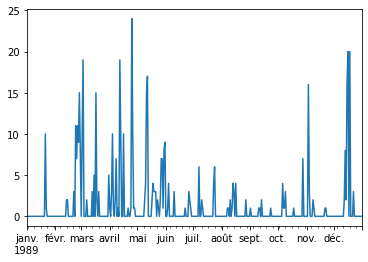

In [22]:
df[df.index.year == 1989]['LG'].plot()

In [20]:
df_cum.idxmin()

LG    1989
LM    1986
dtype: int64